In [273]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import glob
from tqdm import tqdm

## 특정 폴더 내부의 이미지 데이터로 학습 (가위바위보 분류 이미지)

In [3]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/rps.zip'
urllib.request.urlretrieve(url, 'rps.zip')
local_zip = 'rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('images/')
zip_ref.close()

print(glob.glob('images/rps/*'))

['images/rps/paper', 'images/rps/rock', 'images/rps/scissors']


In [418]:
image = datasets.ImageFolder(root='images/rps', 
                                    transform=transforms.Compose([
                                        transforms.ToTensor(), # 이미지를 Tensor 형태로 로드
                                    ])
                                   )

In [419]:
image

Dataset ImageFolder
    Number of datapoints: 2521
    Root location: images/rps
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [420]:
# class 라벨
image.class_to_idx

{'paper': 0, 'rock': 1, 'scissors': 2}

## 하이퍼파라미터 정의

In [480]:
# 배치 사이즈
batch_size = 64

# 학습률
learning_rate = 0.0002

# iteration 횟수
num_epochs = 10

# 평가 지표
loss_func = nn.CrossEntropyLoss()

# trainning set 중 validation 데이터로 사용할 비율
valid_size = 0.2

In [481]:
# validation으로 사용할 trainning indices를 얻는다.
num_train = len(image)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

## 학습/검즘 셋 추출 샘플러
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [482]:
# 학습/검증 셋 지정
train_loader = torch.utils.data.DataLoader(image_folder,         # image_folder를 지정
                                           batch_size=batch_size,# 배치사이즈 지정
                                           sampler=train_sampler, # train_dateset 지정
                                           num_workers=8)       # num_workers 지정
test_loader = torch.utils.data.DataLoader(image_folder,          # 원래는 별도의 Validation Set의 root 경로를 지정해야 한다. 
                                          batch_size=batch_size, # 배치사이즈 지정
                                          sampler=valid_sampler,  # test_dateset 지정
                                          num_workers=8)         # num_workers 지정

In [483]:
# 1개 batch 추출
images, labels = next(iter(train_loader))

In [484]:
# images는 300 X 300 사이즈 RGB 이미지(3채널) 64장(배치사이즈)이 1개 batch로 구성
images.shape, labels.shape

(torch.Size([64, 3, 300, 300]), torch.Size([64]))

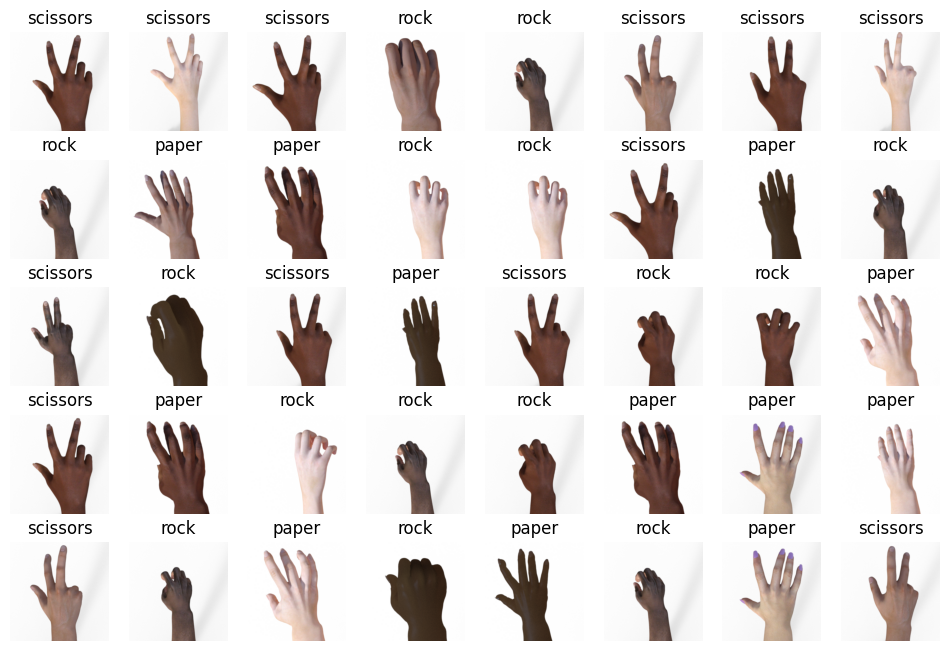

In [485]:
# ImageFolder의 속성 값인 class_to_idx를 할당
labels_map = {v:k for k, v in image_folder.class_to_idx.items()}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

## 분류 CNN 모델

In [486]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [487]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

## 차원수 직접 테스트

In [488]:
# 합성곱층의 차원 확인을 위해서는 직접 레이어를 확인해보면 빠르게 size확인이 가능
m = nn.Conv2d(3, 10, 4).to(device)
m2 = nn.Conv2d(10, 20, 4).to(device)

In [489]:
images.size()

torch.Size([64, 3, 300, 300])

In [490]:
F.max_pool2d(F.relu(m2(F.max_pool2d(F.relu(m(images.to(device))),2))),2).size()

torch.Size([64, 20, 72, 72])

## 모델 정의

In [529]:
## 모델 정의
# 신경망 구성
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 합성곱층
        self.conv1 = nn.Conv2d(3, 10, 4) # 입력 채널 수, 출력 채널 수, 커널크기
        self.conv2 = nn.Conv2d(10, 20, 4)

        # 전결합층
        self.fc1 = nn.Linear(20 * 72 * 72, 50) # 계산상의 20(채널수)* (72 * 72)(레이어를 통과한 이미지 사이즈)
        self.fc2 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 20 * 72 * 72) # 계산상의 10(채널수)* (72 * 72)(레이어를 통과한 이미지 사이즈)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # 일반 softmax에 log를 취해 불안정한 값을 안정화해서 뽑을 수 있고 연산에 효율적임

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [530]:
## 학습 및 테스트 모듈 정의
def train(epoch, num_epochs, model, optimizer,train_loader,test_loader):
    model.train()

    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)

        pred = model(X)
        
        # 손실함수 계산하기
        loss = loss_func(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    score = 0
    # 테스트
    with torch.no_grad():
        for X, Y in test_loader:
            X, Y = X.to(device), Y.to(device)

            pred = model(X)

            # 가장 높은 수치를 가진 라벨 : 최종 예측항목
            output = pred.max(dim=1).indices

            score += (output == Y).sum().item()

    # 정확도 계산
    Accuracy = 100 * float(score) / len(test_loader) / batch_size
    return loss, Accuracy


In [531]:
for epoch in tqdm(range(num_epochs)):
    # train
    loss,Accuracy = train(epoch+1, num_epochs, model, optimizer,train_loader,test_loader)
     
    print(f'Epoch: {epoch+1} - Training loss: {round(loss.item(),5)} Test Accuracy: {round(Accuracy,3)}%')


print('Training completed')

 10%|█         | 1/10 [01:42<15:25, 102.79s/it]

Epoch: 1 - Training loss: 1.04179 Test Accuracy: 47.266%


 20%|██        | 2/10 [03:17<13:05, 98.22s/it] 

Epoch: 2 - Training loss: 0.88148 Test Accuracy: 55.078%


 30%|███       | 3/10 [04:52<11:14, 96.41s/it]

Epoch: 3 - Training loss: 0.65351 Test Accuracy: 86.914%


 40%|████      | 4/10 [06:26<09:33, 95.56s/it]

Epoch: 4 - Training loss: 0.42912 Test Accuracy: 93.75%


 50%|█████     | 5/10 [07:59<07:52, 94.56s/it]

Epoch: 5 - Training loss: 0.25417 Test Accuracy: 93.75%


 60%|██████    | 6/10 [09:33<06:17, 94.36s/it]

Epoch: 6 - Training loss: 0.12184 Test Accuracy: 94.336%


 70%|███████   | 7/10 [11:05<04:41, 93.75s/it]

Epoch: 7 - Training loss: 0.12739 Test Accuracy: 95.312%


 80%|████████  | 8/10 [12:38<03:07, 93.53s/it]

Epoch: 8 - Training loss: 0.07268 Test Accuracy: 95.703%


 90%|█████████ | 9/10 [14:13<01:33, 93.80s/it]

Epoch: 9 - Training loss: 0.07998 Test Accuracy: 96.289%


100%|██████████| 10/10 [15:53<00:00, 95.31s/it]

Epoch: 10 - Training loss: 0.03711 Test Accuracy: 97.461%
Training completed


In [532]:
#valid set batch 추출
images, labels = next(iter(test_loader))

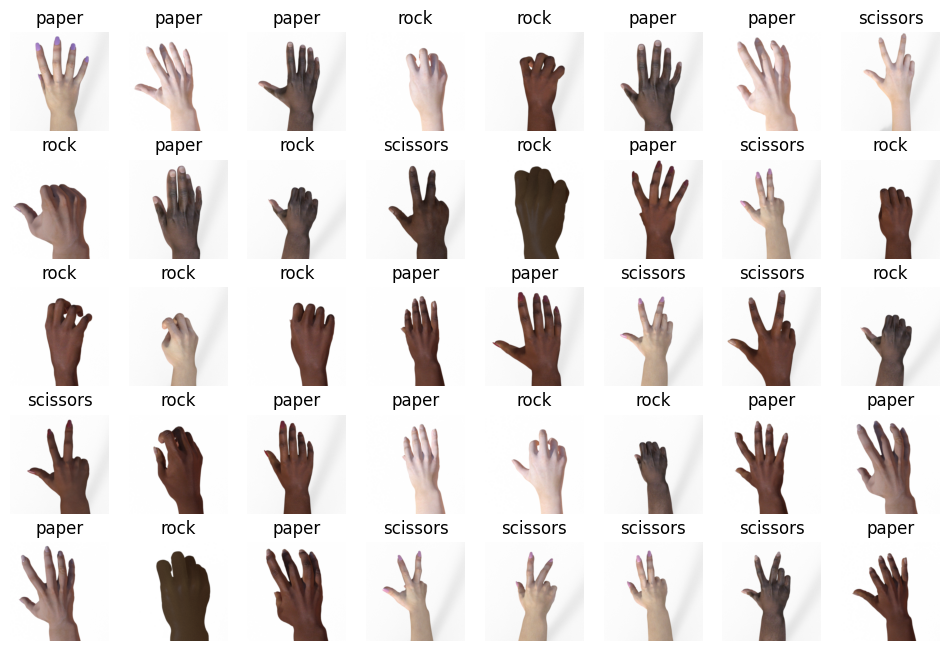

In [533]:
figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 5
for i in range(1, cols*rows + 1):
    # sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[i-1], labels[i-1].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

In [539]:
## 학습 후 배치에 테스트
score = labels.to(device) == model(images.to(device)).max(dim=1).indices

In [547]:
print(f'ACC : {round((score.sum()/len(score)).item() * 100)}%')

ACC : 100%
